# LIM forecasting: multivariate separate sic each month

Katie Brennan  
started March 2021  
  
#### Goals: 
* Build a LIM based on SIC 
* Build a LIM based on both SIC and SIT 
* Compare performance

In [1]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

import time as timestamp 

In [2]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils as lim

import LIM_utils_kb as limkb

In [3]:
sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")
import LMR_utils

In [4]:
import importlib
importlib.reload(limkb)
importlib.reload(lim)

<module 'LIM_utils' from '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_utils.py'>

In [5]:
arc_proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                              central_longitude=-45,
                                              true_scale_latitude=0.1))
proj = dict(projection=ccrs.Robinson(central_longitude=0.),zorder=1)

In [6]:
# number of EOFs to retain for the LIM state vector
ntrunc = 400 # EOF truncation for individual fields (reduced-state space)
nmodes = 60 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 25
nmodes_sic = 50
#modes_sic = 20

# forecast lead time in months that defines the LIM training
tau = 1

# training data defined by the first ntrain times
# fraction of years used in training
# ensures that start year of both train and validation data is january 
ntrain = 0.60

# variables to include in the LIM (note "vars" is a Python command)
#limvars = ['tas','zg']
#limvars = ['tas','rlut','zg']
#limvars = ['sic']
#limvars = ['tas','sic']
#limvars = ['tas','sic','zg','psl','pr','tos']
#limvars = ['tas','psl','tos','sit','sic']
#limvars = ['tas','tos','psl','sit','sic']
#limvars_nosic = ['tas','tos','psl','sit']
limvars = ['tas','tos','sic']
limvars_nosic = ['tas','tos']

nvars = len(limvars)

# specify the model source 
train_dsource = 'mpi_lm_kb'
#train_dsource = 'ccsm4_lm_kb'
valid_dsource = 'mpi_lm_kb'
#valid_dsource = 'ccsm4_lm_kb'

sic_separate = True

In [7]:
full_names = {'tas':'Surface air temperature',
              'psl':'Sea level Pressure',
              'sic':'Sea ice concentration', 
              'sit':'Sea ice thickness',
              'tos':'Sea surface temperature',
              'zg': '500hPa geopotential height'}

areawt_name = {'tas':'areacella',
               'psl':'areacella',
               'sic':'areacello', 
               'sit':'areacello',
               'tos':'areacello',
               'zg': 'areacella'}

month_names = ['January','Februrary','March','April','May','June','July','August',
               'September','October','November','December']

In [8]:
from datetime import date

today = date.today()

#Year-month-day
today_date = today.strftime("%Y%m%d")

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
def sub_arctic_plot(ax,fig,pdat,lat,lon,maxv=-1,
                    minv=-1,colorbar=True,extent=True,cmap='bwr'):
    nlat = lat.shape[0]
    nlon = lon.shape[1]
                    
    if maxv == -1:
        maxv = np.nanmax(pdat)
    if minv == -1:
        minv = -maxv                
           
#    pdat_wrap, lon_wrap = add_cyclic_point(pdat,coord=lon[0,:], axis=1)
#    new_lon2d, new_lat2d = np.meshgrid(lon_wrap, lat)
                    
    if extent is True: 
        ax.set_extent([-150, 140, 50, 90], crs=ccrs.PlateCarree())
    ax.gridlines(linestyle='--')
    ax.add_feature(cfeature.LAND, facecolor=(1, 1, 1))
    cs = ax.pcolormesh(lon, lat, pdat, 
                       vmin=minv, vmax=maxv, cmap=cmap, 
                       transform=ccrs.PlateCarree())
    ax.coastlines(resolution='110m', linewidth=0.5)
    if colorbar is True:
        plt.colorbar(cs, ax=ax)
        
    return 

In [11]:
def load_data(var, var_dict, fdic, remove_climo=True, detrend=True, verbose=True): 
    """
    INPUTS:
    =========
    limvars:   list of strings with variable names 
    fdic:   dictionary of variables names, location and filenames 
            (results from build_training_dic())
    remove_climo: True/False whether anomalies are returned or not
    detrend:  True/False whether detrended data is returned or not 
    verbose:  True/False whether print statements or not
    
    OUTPUTS: 
    ==========
    X_all:    concatenated array of all variables in limvars, 
              stacked along 1D spatial dimension
    var_dict: dictionary with variables as keys, contains index location in X_all, 
              lat values, lon values, and 1D spatial dimension (number of DOF) 
              for each variable. 
    """

    begin_time = timestamp.time()
    if verbose is True: 
        print('Loading '+var)

    data_in = xr.open_dataset(fdic[var])

    if var is 'zg':
        data_in = data_in.sel(plev=5e4)    
    vardims = list(data_in[var].dims)
    
    if len(vardims)<=2:
        nlat = data_in[vardims[0]].shape[0]
        nlon = data_in[vardims[1]].shape[0]
        ndof = nlat*nlon
    elif len(vardims)>=3:
        ntime = data_in[vardims[0]].shape[0]
        nlat = data_in[vardims[1]].shape[0]
        nlon = data_in[vardims[2]].shape[0]
        ndof = nlat*nlon

    if remove_climo is True: 
        climo = data_in[var].groupby('time.month').mean(dim='time')
        x_var_anom = data_in[var].groupby('time.month')- climo

        x_var = x_var_anom.values
    else: 
        x_var = data_in[var].values

    if detrend is True: 
        var_nans_mask = np.where(np.isnan(x_var),np.nan,1)
        var_dt = spy.signal.detrend(np.where(np.isnan(x_var),0,x_var),axis=0)
        x_var_dt = var_dt*var_nans_mask
    else: 
        x_var_dt = x_var

    if len(vardims)<=2:
        X_var = np.reshape(x_var_dt,[ndof]) 
    else: 
        X_var = np.moveaxis(np.reshape(x_var_dt,[ntime,ndof]),0,-1) 

    # save location indices for each variable
    d = {}
#    d['varind'] = k
    
    if len(vardims)<=2:
        d['lat'] = data_in.lat.values
        d['lon'] = data_in.lon.values
        if var == 'areacello':
            d['units'] = data_in.areacello.units
        elif var == 'areacella':
            d['units'] = data_in.areacella.units
    elif len(vardims)>=3:
        d['lat'] = data_in.lat.values
        d['lon'] = data_in.lon.values
        d['time'] = data_in.time.values
        
    d['var_ndof'] = ndof
    var_dict[var] = d

    elapsed_time = timestamp.time() - begin_time
    if verbose is True: 
        print('-----------------------------------------------------')
        print('completed in ' + str(elapsed_time) + ' seconds')
        print('-----------------------------------------------------')
            
    return X_var, var_dict

In [12]:
def step1_compress_individual_vars(X_train, limvars, ntrunc, nmodes_sic, var_dict, 
                                   X_allshape, X_sicshape, wt, sic_separate=False): 
    
    nvars = len(limvars)
    W_all = {}
    standard_factor = {}
    tot_var = {}
    tot_var_eig = {}
    
    if sic_separate is True: 
        E3 = np.zeros([X_allshape-X_sicshape,ntrunc*(nvars-1)])
    else:  
        E3 = np.zeros([X_allshape,ntrunc*(nvars)])
    n=0

    for k,var in enumerate(limvars):
        print('decomposing...',var)
        # weight matrix for equal-area covariance normalization
        ndof = var_dict[var]['var_ndof']
        ntime = X_train.shape[1]
        LAT = var_dict[var]['lat']
        if len(LAT.shape)<2:
            nlon = var_dict[var]['lon'].shape[0]
            nlat = var_dict[var]['lat'].shape[0]
            lat = LAT[:,np.newaxis]*np.ones((nlat,nlon))
        else: 
            lat = LAT
            
        if (sic_separate is True) & (var is 'sic'):
            trunc = nmodes_sic
        else: 
            trunc = ntrunc
        
        [eofs_out, svals_out, pcs_out, 
         total_var, total_var_eig, 
         var_expl_by_retained, W] = eof_decomp_1var(X_train[var_dict[var]['var_inds'],:],
                                                    lat,ndof,ntime,trunc,Weight=wt)
        tot_var[var] = total_var
        tot_var_eig[var] = total_var_eig
        W_all[var] = np.squeeze(W)
        
        if (sic_separate is True) & (var is 'sic'):
            print('fraction in first '+str(nmodes_sic)+ ' '+limvars[k]+' EOFs = '+str(var_expl_by_retained))
        else: 
            print('fraction in first '+str(ntrunc)+ ' '+limvars[k]+' EOFs = '+str(var_expl_by_retained))


        if k == 0:
            # projection
            P_var = np.matmul(eofs_out.T,W*np.nan_to_num(X_train[var_dict[var]['var_inds'],:]))
            standard_factor[var] = np.sqrt(np.sum(svals_out*svals_out)/(ntime-1))
            
            Ptrunc = P_var/standard_factor[var]

            # reverse operator from EOFs to grid point space
            E3[var_dict[var]['var_inds'],k*ntrunc:(k+1)*ntrunc] = eofs_out*standard_factor[var]
            n=n+1
        elif (sic_separate is True) & (var is 'sic'):
            print('...separately')
            Pvar_sic = np.matmul(eofs_out.T,W*np.nan_to_num(X_train[var_dict[var]['var_inds'],:]))
            standard_factor[var] = np.sqrt(np.sum(svals_out*svals_out)/(ntime-1))
            
            Ptrunc_sic = Pvar_sic/standard_factor[var]
            E_sic = eofs_out*standard_factor[var]
        else:
            # projection
            P_var = np.matmul(eofs_out.T,W*np.nan_to_num(X_train[var_dict[var]['var_inds'],:]))
            standard_factor[var] = np.sqrt(np.sum(svals_out*svals_out)/(ntime-1))
            
            Ptrunc = np.concatenate((Ptrunc,P_var/standard_factor[var]),axis=0)

            # reverse operator from EOFs to grid point space
            E3[var_dict[var]['var_inds'],n*ntrunc:(n+1)*ntrunc] = eofs_out*standard_factor[var]
            n=n+1
    if sic_separate is True: 
        return Ptrunc, E3, Ptrunc_sic, E_sic, W_all, standard_factor, tot_var, tot_var_eig
    else: 
        return Ptrunc, E3, W_all, standard_factor, tot_var, tot_var_eig

In [13]:
def step1_compress_individual_var(X_train, var, ntrunc, nmodes_sic, var_dict,n,areawt=0,
                                  wt=True, sic_separate=False): 
    """
    """
    if (sic_separate is True) & (var is 'sic'):
            trunc = nmodes_sic
    else: 
        trunc = ntrunc
        
    if len(var_dict[var]['lat'].shape)<2:
        nlon = var_dict[var]['lon'].shape[0]
        nlat = var_dict[var]['lat'].shape[0]
        lat = var_dict[var]['lat'][:,np.newaxis]*np.ones((nlat,nlon))
    else: 
        lat = var_dict[var]['lat']

    [eofs_out, svals_out, pcs_out, 
     total_var, total_var_eig, 
     var_expl_by_retained, W] = eof_decomp_1var(X_train,lat,var_dict[var]['var_ndof'],
                                                X_train.shape[1],trunc,areawt=areawt,Weight=wt)
    
    W_all = np.squeeze(W)
    ntime = X_train.shape[1]

    print('fraction in first '+str(ntrunc)+ ' '+limvars[k]+' EOFs = '+str(var_expl_by_retained))

    # projection
    P_var = np.matmul(eofs_out.T,W*np.nan_to_num(X_train))
    standard_factor[var] = np.sqrt(np.sum(svals_out*svals_out)/(ntime-1))

    Ptrunc = P_var/standard_factor[var]

    # reverse operator from EOFs to grid point space
    E3 = eofs_out*standard_factor[var]
        
    return Ptrunc, E3, tot_var, tot_var_eig, W_all

In [14]:
# def step1_compress_individual_var(X_train, ntrunc, nmodes_sic, var_dict,n, areawt=0,
#                                   wt=True, sic_separate=False): 
#     """
#     """
#     if (sic_separate is True) & (var is 'sic'):
#             trunc = nmodes_sic
#     else: 
#         trunc = ntrunc
        
#     if len(var_dict[var]['lat'].shape)<2:
#         nlon = var_dict[var]['lon'].shape[0]
#         nlat = var_dict[var]['lat'].shape[0]
#         lat = var_dict[var]['lat'][:,np.newaxis]*np.ones((nlat,nlon))
#     else: 
#         lat = var_dict[var]['lat']

#     [eofs_out, svals_out, pcs_out, 
#      total_var, total_var_eig, 
#      var_expl_by_retained, W] = eof_decomp_1var(X_train,lat,var_dict[var]['var_ndof'],
#                                                 X_train.shape[1],trunc,areawt=areawt,Weight=wt)
    
#     W_all = np.squeeze(W)
#     ntime = X_train.shape[1]
    
# #     if k == 0:
# #         print('fraction in first '+str(ntrunc)+ ' '+limvars[k]+' EOFs = '+str(var_expl_by_retained))
                                                                              
# #         # projection
# #         P_var = np.matmul(eofs_out.T,W*np.nan_to_num(X_train))
# #         standard_factor[var] = np.sqrt(np.sum(svals_out*svals_out)/(ntime-1))

# #         Ptrunc[var] = P_var/standard_factor[var]

# #         # reverse operator from EOFs to grid point space
# #         E3[var] = eofs_out*standard_factor[var]
# #         n=n+1

#     if (sic_separate is True) & (var is 'sic'):
#         print('fraction in first '+str(nmodes_sic)+ ' '+limvars[k]+' EOFs = '+str(var_expl_by_retained))
#         print('...separately')

#         Pvar_sic = np.matmul(eofs_out.T,W*np.nan_to_num(X_train))
#         standard_factor[var] = np.sqrt(np.sum(svals_out*svals_out)/(ntime-1))

#         Ptrunc = Pvar_sic/standard_factor[var]
#         E3 = eofs_out*standard_factor[var]

#     else:
#         print('fraction in first '+str(ntrunc)+ ' '+limvars[k]+' EOFs = '+str(var_expl_by_retained))

#         # projection
#         P_var = np.matmul(eofs_out.T,W*np.nan_to_num(X_train))
#         standard_factor[var] = np.sqrt(np.sum(svals_out*svals_out)/(ntime-1))

#         Ptrunc = P_var/standard_factor[var]

#         # reverse operator from EOFs to grid point space
#         E3 = eofs_out*standard_factor[var]
#         n=n+1
        
#     return Ptrunc, E3, tot_var, tot_var_eig, W_all

In [15]:
def count_ndof_all(limvars, E3, sic_separate=False): 
    #Count total degrees of freedom: 
    if sic_separate is True: 
        limvars_nosic = [l for l in limvars if l not in 'sic']
        for v,var in enumerate(limvars_nosic):
            if v == 0: 
                ndof_all = E3[var].shape[0]
            else: 
                ndof_all = ndof_all+E3[var].shape[0]
    else: 
        for v,var in enumerate(limvars):
            if v == 0: 
                ndof_all = E3[var].shape[0]
            else: 
                ndof_all = ndof_all+E3[var].shape[0]
            print(ndof_all)
            
    return ndof_all

In [16]:
def stack_variable_eofs(limvars, ndof_all, ntrunc, Ptrunc, E3, 
                        var_dict,nmonths=1,sic_separate=False, 
                        verbose=False): 
    start = 0
    if sic_separate is True: 
        limvars_nosic = [l for l in limvars if l not in 'sic']
        nvars = len(limvars_nosic)
        E3_all = np.zeros([ndof_all,int(ntrunc*(nvars)),nmonths])
        if nmonths == 1: 
            E3_all = np.squeeze(E3_all)

        for v,var in enumerate(limvars_nosic):
            if v == 0: 
                Ptrunc_all = Ptrunc[var]
            else: 
                Ptrunc_all = np.concatenate((Ptrunc_all,Ptrunc[var]),axis=0)
            E3_all[var_dict[var]['var_inds'],int(v*ntrunc):int((v+1)*ntrunc)] = E3[var]
            
            if verbose is True: 
                print(E3_all[18430:18435,0])
                print('start: '+str(start)+' end: '+str(start+var_dict[var]['var_ndof'])+' '+str(v*ntrunc))
#            start = start+var_dict[var]['var_ndof']

        Ptrunc_sic = Ptrunc['sic']
        E_sic = E3['sic']
    else: 
        nvars = len(limvars)
        E3_all = np.zeros([ndof_all,int(ntrunc*(nvars))])
        if nmonths == 1: 
            E3_all = np.squeeze(E3_all)

        for v,var in enumerate(limvars):
            if v == 0: 
                Ptrunc_all = Ptrunc[var]
            else: 
                Ptrunc_all = np.concatenate((Ptrunc_all,Ptrunc[var]),axis=0)
            E3_all[var_dict[var]['var_inds'],int(v*ntrunc):int((v+1)*ntrunc)] = E3[var]
            
            if verbose is True:
                print(E3_all[18430:18435,0])
                print('start: '+str(start)+' end: '+str(start+var_dict[var]['var_ndof'])+' '+str(v*ntrunc))
#            start = start+var_dict[var]['var_ndof']
            
    if sic_separate == True:     
        return Ptrunc_all, E3_all, Ptrunc_sic, E_sic
    else: 
        return Ptrunc_all, E3_all

In [17]:
def eof_decomp_1var(X,lat,ndof,ntime,ntrunc,areawt=0,Weight=True): 
    """
    INPUTS: 
    ========
    X = (ndof, ntime)
    lat = latitude values 
    ndof = integer value (nlat x nlon)
    ntime = integer value (number of timesteps)
    ntrunc = integer value (number of single variable eof modes to retain)
    Weights = True/False, indicates whether to weight by cos(latitude) or not
    
    OUTPUTS: 
    =========
    eofs_out
    svals_out
    pcs_out
    total_var
    tot_var_eig
    var_expl_by_retained
    W
    """
    
    if Weight is True: 
        if len(areawt.shape)<=1:
            W = areawt[:,np.newaxis]
        else: 
            W = areawt
        inp = W*np.nan_to_num(X)
        
    else: 
        inp = np.nan_to_num(X)

    u,s,v = np.linalg.svd(inp,full_matrices=False)

    eofs_out = u[:,:ntrunc]
    svals_out = s[:ntrunc]
    pcs_out = v[:ntrunc]

    eig_vals = (svals_out**2)
    total_var = np.nansum(np.nanvar(X,ddof=1,axis=1))
    tot_var_eig = np.sum(s*s)
    var_expl_by_retained = 100*np.sum(eig_vals)/tot_var_eig
    
    if Weight is True: 
        return eofs_out, svals_out, pcs_out, total_var, tot_var_eig, var_expl_by_retained, W
    else: 
        return eofs_out, svals_out, pcs_out, total_var, tot_var_eig, var_expl_by_retained

In [18]:
def decompress_eof_separate_sic2(P_train,nmodes,nmodes_sic,E,E_sic,
                                 limvars,var_dict,W_all,Weights=True,
                                 sic_separate=False):
    if sic_separate is True: 
        x_multivar = P_train[0:nmodes,:]
        x_sic = P_train[-nmodes_sic:,:]

        x_train_multi_dcomp = np.matmul(E,x_multivar)
        x_train_sic_dcomp = np.matmul(E_sic,x_sic)
        x_train_dcomp = np.concatenate((x_train_multi_dcomp,x_train_sic_dcomp),axis=0)
    else: 
        x_multivar = P_train

        x_train_dcomp = np.matmul(E,x_multivar)

    if Weights is True: 
        X_train_dcomp = unweight_decompressed_vars(x_train_dcomp, limvars, var_dict, W_all)
    else: 
        X_train_dcomp = x_train_dcomp
    
    return X_train_dcomp

## Check Decomposition: 

In [62]:
pi = np.pi

# fill continents if plotting SST; otherwise no
# if var_to_extract == 'tos':
#     noland = True
# else:
#     noland = False

infile_20cr_tas = '/home/disk/kalman3/rtardif/LMR/data/model/20cr/tas_sfc_Amon_20CR_185101-201112.nc'

fdic_ccsm4 = limkb.build_training_dic(train_dsource)
fdic_mpi = limkb.build_training_dic(valid_dsource)

In [63]:
fdic_ccsm4 

{'fpath': '/home/disk/katabatic/wperkins/data/LMR/data/model/ccsm4_last_millenium/',
 'tos': '/home/disk/katabatic/wperkins/data/LMR/data/model/ccsm4_last_millenium/tos_sfc_Omon_CCSM4_past1000_085001-185012.nc',
 'tas': '/home/disk/katabatic/wperkins/data/LMR/data/model/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc',
 'zg': '/home/disk/katabatic/wperkins/data/LMR/data/model/ccsm4_last_millenium/zg_500hPa_Amon_CCSM4_past1000_085001-185012.nc',
 'rlut': '/home/disk/katabatic/wperkins/data/LMR/data/model/ccsm4_last_millenium/rlut_toa_Amon_CCSM4_past1000_085001-185012.nc',
 'sic': '/home/disk/chaos/mkb22/Documents/SeaIceData/CCSM4/CCSM4_last_millennium/sic_sfc_OImon_CCSM4_past1000_085001-185012.nc',
 'psl': '/home/disk/katabatic/wperkins/data/LMR/data/model/ccsm4_last_millenium/psl_sfc_Amon_CCSM4_past1000_085001-185012.nc',
 'pr': '/home/disk/katabatic/wperkins/data/LMR/data/model/ccsm4_last_millenium/pr_sfc_Amon_CCSM4_past1000_085001-185012.nc',
 'sit': '/home/disk/cha

In [20]:
areacell = {}
areacella_dict = {}
areacell['areacella'], areacella_dict = limkb.load_data('areacella', areacella_dict, fdic_ccsm4, 
                                                         remove_climo=False, detrend=False, verbose=False)

areacello_dict = {}
areacell['areacello'], areacello_dict = limkb.load_data('areacello', areacello_dict, fdic_ccsm4, 
                                                         remove_climo=False, detrend=False, verbose=False)

areacell_dict = {}
areacell_dict['areacello'] = areacello_dict
areacell_dict['areacella'] = areacella_dict

In [64]:
wt=True
var_dict = {}
tot_var = {}
tot_var_eig = {}
W_all = {}
standard_factor = {}
E3 = {}
Ptrunc = {}

# if sic_separate is True: 
#         E3 = np.zeros([X_allshape-X_sicshape,ntrunc*(nvars-1)])
# else:  
#     E3 = np.zeros([X_allshape,ntrunc*(nvars)])
n=0

for k, var in enumerate(['tas','sic']): 
    X_var, var_dict = limkb.load_data(var, var_dict, fdic_ccsm4, remove_climo=True, detrend=True, verbose=True)
    
    mo = 1
    tsamp = X_var.shape[1]
    nyears_train = int((tsamp*ntrain)/12)
    #nyears_valid = int(X_all_mpi.shape[2]/12)
    nyears_valid = int((tsamp*(1-ntrain))/12)

    X_t = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))
    X_train = X_t[:,0:nyears_train,mo]
    X_train2 = X_t[:,0:nyears_train,mo+1]
    X_valid = X_t[:,nyears_train:,mo]
#    truth = X_t[:,nyears_train:,mo+1]
    ntime = X_train.shape[1]
     
    [Ptrunc, E3, tot_var,
    tot_var_eig, W_all] = limkb.step1_compress_individual_var(X_train, ntrunc, nmodes_sic, var_dict, n, 
                                                              areawt=areacell[areawt_name[var]],
                                                              wt=wt, sic_separate=sic_separate)

    del X_var

Loading tas
-----------------------------------------------------
completed in 32.321396350860596 seconds
-----------------------------------------------------
fraction in first 400 tas EOFs = 99.10731018681433
Loading sic


KeyboardInterrupt: 

In [203]:
ndof_all = limkb.count_ndof_all(['tas','sic'], E3, sic_separate=sic_separate)

[Ptrunc_all, E3_all, 
Ptrunc_sic, E_sic] = limkb.stack_variable_eofs(['tas','sic'], ndof_all, ntrunc, Ptrunc, E3, 
                                        var_dict, sic_separate=sic_separate)

[P_train, Fvar, E] = limkb.step2_multivariate_compress(Ptrunc_all,nmodes, E3_all, Ptrunc_sic, 
                                                       sic_separate=sic_separate)

Fraction in first 60 multivariate EOFs = 83.17044246833852
Shape of E: (18432, 60)


In [204]:
x_train_dcomp = limkb.decompress_eof_separate_sic(P_train,nmodes,nmodes_sic,E,E_sic,
                                                  ['tas','sic'],var_dict,W_all,Weights=True,
                                                  sic_separate=sic_separate)

In [205]:
x_sic_decomp = x_train_dcomp[18432:,]

v = {}
X_sic,_ = limkb.load_data('sic', v, fdic_ccsm4, remove_climo=True, detrend=True, verbose=True)

Loading sic
-----------------------------------------------------
completed in 94.50121188163757 seconds
-----------------------------------------------------


In [206]:
mo = 1
tsamp = X_sic.shape[1]
nyears_train = int((tsamp*ntrain)/12)
#nyears_valid = int(X_all_mpi.shape[2]/12)
nyears_valid = int((tsamp*(1-ntrain))/12)

X_t = np.reshape(X_sic,(X_sic.shape[0],int(tsamp/12),12))
X_sic = X_t[:,0:nyears_train,mo]

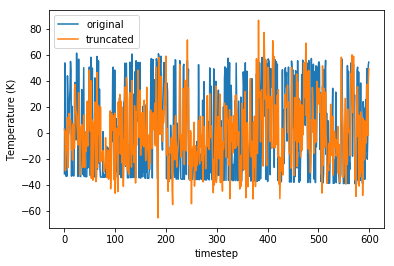

In [212]:
ii=10080
ii=6080

plt.plot(X_sic[ii,:], label='original')
plt.plot(x_sic_decomp[ii,:], label='truncated')

#plt.xlim(0,100)
# plt.ylim(-20,30)
plt.ylabel('Temperature (K)')
plt.xlabel('timestep')
plt.legend()

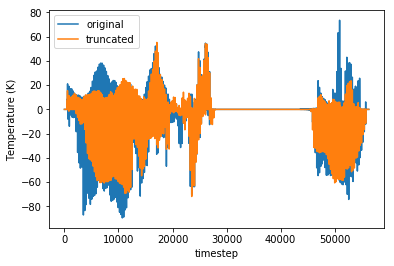

In [211]:
ii=100

plt.plot(X_sic[:,ii], label='original')
plt.plot(x_sic_decomp[:,ii], label='truncated')

#plt.xlim(0,100)
# plt.ylim(-20,30)
plt.ylabel('Temperature (K)')
plt.xlabel('timestep')
plt.legend()

## Load and preprocess data: 

In [20]:
pi = np.pi

# fill continents if plotting SST; otherwise no
# if var_to_extract == 'tos':
#     noland = True
# else:
#     noland = False

infile_20cr_tas = '/home/disk/kalman3|/rtardif/LMR/data/model/20cr/tas_sfc_Amon_20CR_185101-201112.nc'

fdic_ccsm4 = limkb.build_training_dic(train_dsource)
fdic_mpi = limkb.build_training_dic(valid_dsource)

In [21]:
areacell = {}
areacella_dict = {}
areacell['areacella'], areacella_dict = limkb.load_data('areacella', areacella_dict, fdic_ccsm4, 
                                                        remove_climo=False, detrend=False, verbose=False)

areacello_dict = {}
areacell['areacello'], areacello_dict = limkb.load_data('areacello', areacello_dict, fdic_ccsm4, 
                                                        remove_climo=False, detrend=False, verbose=False)

areacell_dict = {}
areacell_dict['areacello'] = areacello_dict
areacell_dict['areacella'] = areacella_dict

In [52]:
# load training data...
mo = 1

wt=True
var_dict = {}
tot_var = {}
tot_var_eig = {}
W_all = {}
E3 = {}
Ptrunc = {}

tot_var2 = {}
tot_var_eig2 = {}
W_all2 = {}
E3_2 = {}
Ptrunc2 = {}

tot_var_valid = {}
tot_var_eig_valid = {}
W_all_valid = {}
E3_valid = {}
Ptrunc_valid = {}

n=0

for k, var in enumerate(limvars): 
    X_var, var_dict = limkb.load_data(var, var_dict, fdic_ccsm4, remove_climo=True, 
                                      detrend=True, verbose=True)
    
    tsamp = X_var.shape[1]
    nyears_train = int((tsamp*ntrain)/12)
    #nyears_valid = int(X_all_mpi.shape[2]/12)
    nyears_valid = int((tsamp*(1-ntrain))/12)

    X_t = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))
    X_train = X_t[:,0:nyears_train,mo]
    X_train2 = X_t[:,0:nyears_train,mo+1]
    X_valid = X_t[:,nyears_train:,mo]
#    truth = X_t[:,nyears_train:,mo+1]
    ntime = X_train.shape[1]
     
    [Ptrunc[var], E3[var], tot_var[var],tot_var_eig[var], 
     W_all[var]] = limkb.step1_compress_individual_var(X_train, var, ntrunc, nmodes_sic, var_dict, n, 
                                                        areawt=areacell[areawt_name[var]],
                                                        wt=wt, sic_separate=sic_separate)
    [Ptrunc2[var], E3_2[var], tot_var2[var],tot_var_eig2[var], 
     W_all2[var]] = limkb.step1_compress_individual_var(X_train2, var,ntrunc, nmodes_sic, var_dict, n, 
                                                        areawt=areacell[areawt_name[var]],
                                                        wt=wt, sic_separate=sic_separate)
    
    [Ptrunc_valid[var], E3_valid[var], tot_var_valid[var],tot_var_eig_valid[var],
     W_all_valid[var]] = limkb.step1_compress_individual_var(X_valid, var,ntrunc, nmodes_sic, var_dict, n, 
                                                             areawt=areacell[areawt_name[var]],
                                                             wt=wt, sic_separate=sic_separate)
#     for m in range(12):
#         X_valid = X_t[:,nyears_train:,m]
        
#         [Ptrunc_valid, E3_valid, tot_var_valid,
#         tot_var_eig_valid, W_all_valid] = step1_compress_individual_var(X_valid, ntrunc, nmodes_sic, var_dict, n, 
#                                                                         areawt=areacell[areawt_name[var]],
#                                                                         wt=wt, sic_separate=sic_separate)
#         Ptrunc_valid_var[:,:,m] = Ptrunc_valid[var]
#         E3_valid_var[:,:,m] = E3_valid[var]
        
    del X_var

Loading tas
-----------------------------------------------------
completed in 22.467074871063232 seconds
-----------------------------------------------------
fraction in first 400 tas EOFs = 98.65591533463811
fraction in first 400 tas EOFs = 98.54226870664989
fraction in first 400 tas EOFs = 100.0
Loading tos
-----------------------------------------------------
completed in 32.48222470283508 seconds
-----------------------------------------------------
fraction in first 400 tos EOFs = 97.28004605750843
fraction in first 400 tos EOFs = 97.2581661806435
fraction in first 400 tos EOFs = 100.0
Loading sic
-----------------------------------------------------
completed in 40.4226610660553 seconds
-----------------------------------------------------
fraction in first 400 sic EOFs = 89.86320503915805
fraction in first 400 sic EOFs = 90.16346671061257
fraction in first 400 sic EOFs = 89.73027725521601


In [23]:
# # Try trunctating two months in a row together rather than separate
# # load training data...
# mo = 1

# wt=True
# var_dict = {}
# tot_var = {}
# tot_var_eig = {}
# W_all = {}
# E3 = {}
# Ptrunc = {}

# Ptrunc_valid = {}
# tot_var_valid = {}
# tot_var_eig_valid = {}
# W_all_valid = {}
# E3_valid = {}

# n=0

# for k, var in enumerate(limvars): 
#     X_var, var_dict = load_data(var, var_dict, fdic_ccsm4, remove_climo=True, detrend=True, verbose=True)
    
#     tsamp = X_var.shape[1]
#     nyears_train = int((tsamp*ntrain)/12)
#     #nyears_valid = int(X_all_mpi.shape[2]/12)
#     nyears_valid = int((tsamp*(1-ntrain))/12)

#     X_t = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))
#     X_train = X_t[:,0:nyears_train,mo:mo+2]
#     X_train_2d = np.reshape(X_train, (X_train.shape[0],X_train.shape[1]*2))
#     X_valid = X_t[:,nyears_train:,mo]
# #    truth = X_t[:,nyears_train:,mo+1]
#     ntime = X_train_2d.shape[1]
     
#     [Ptrunc[var], E3[var], tot_var[var],tot_var_eig[var], 
#      W_all[var]] = step1_compress_individual_var(X_train_2d, var, ntrunc, nmodes_sic, var_dict, n, 
#                                                  areawt=areacell[areawt_name[var]],
#                                                  wt=wt, sic_separate=sic_separate)
    
#     [Ptrunc_valid[var], E3_valid[var], tot_var_valid[var],tot_var_eig_valid[var], 
#      W_all_valid[var]] = step1_compress_individual_var(X_valid, var, ntrunc, nmodes_sic, var_dict, n, 
#                                                        areawt=areacell[areawt_name[var]],
#                                                        wt=wt, sic_separate=sic_separate)
# #     for m in range(12):
# #         X_valid = X_t[:,nyears_train:,m]
        
# #         [Ptrunc_valid, E3_valid, tot_var_valid,
# #         tot_var_eig_valid, W_all_valid] = step1_compress_individual_var(X_valid, ntrunc, nmodes_sic, var_dict, n, 
# #                                                                         areawt=areacell[areawt_name[var]],
# #                                                                         wt=wt, sic_separate=sic_separate)
# #         Ptrunc_valid_var[:,:,m] = Ptrunc_valid[var]
# #         E3_valid_var[:,:,m] = E3_valid[var]
        
#     del X_var


Loading tas
-----------------------------------------------------
completed in 16.28117346763611 seconds
-----------------------------------------------------
fraction in first 400 tas EOFs = 96.90980537658456
fraction in first 400 tas EOFs = 100.0
Loading tos
-----------------------------------------------------
completed in 57.30955171585083 seconds
-----------------------------------------------------
fraction in first 400 tos EOFs = 95.26328111290806
fraction in first 400 tos EOFs = 100.0
Loading sic
-----------------------------------------------------
completed in 52.39989757537842 seconds
-----------------------------------------------------
fraction in first 400 sic EOFs = 89.21172817246126
fraction in first 400 sic EOFs = 89.73027725521601


In [53]:
# Get indices for each variable:
start = 0
for k, var in enumerate(limvars): 
    print('working on '+var)
    inds = var_dict[var]['var_ndof']
    var_inds = np.arange(start,start+inds,1)
    start = inds+start
    
    var_dict[var]['var_inds'] = var_inds

working on tas
working on tos
working on sic


In [54]:
ndof_all = limkb.count_ndof_all(limvars, E3, sic_separate=sic_separate)

[Ptrunc_all, E3_all, 
Ptrunc_sic, E_sic] = limkb.stack_variable_eofs(limvars, ndof_all, ntrunc, Ptrunc, E3, 
                                         var_dict, sic_separate=sic_separate)

[P_train, Fvar, E] = limkb.step2_multivariate_compress(Ptrunc_all,nmodes, E3_all, Ptrunc_sic, 
                                                       sic_separate=sic_separate)

Fraction in first 60 multivariate EOFs = 74.16477580087317
Shape of E: (74752, 60)


In [55]:
ndof_all2 = limkb.count_ndof_all(limvars, E3_2, sic_separate=sic_separate)

[Ptrunc_all2, E3_all2,
 Ptrunc_sic2, E_sic2] = limkb.stack_variable_eofs(limvars, ndof_all2, ntrunc, Ptrunc2, E3_2, 
                                           var_dict, sic_separate=sic_separate)

[P_train2, Fvar2, E_2] = limkb.step2_multivariate_compress(Ptrunc_all2,nmodes, E3_all2, Ptrunc_sic2, 
                                                           sic_separate=sic_separate)

Fraction in first 60 multivariate EOFs = 73.30754587807237
Shape of E: (74752, 60)


In [56]:
ndof_all_valid = limkb.count_ndof_all(limvars, E3_valid, sic_separate=sic_separate)

[Ptrunc_all_valid, E3_all_valid,
 Ptrunc_sic_valid, E_sic_valid] = limkb.stack_variable_eofs(limvars, ndof_all_valid, ntrunc, Ptrunc_valid, E3_valid, 
                                                      var_dict, sic_separate=sic_separate)

[P_train_valid, Fvar_valid, 
 E_valid] = limkb.step2_multivariate_compress(Ptrunc_all_valid,nmodes, E3_all_valid, Ptrunc_sic_valid,
                                              sic_separate=sic_separate)

Fraction in first 60 multivariate EOFs = 74.86678460241099
Shape of E: (74752, 60)


In [58]:
P_train_valid.shape, P_train.shape, P_train2.shape

((110, 400), (110, 600), (110, 600))

In [34]:
nmo = int(P_train.shape[1]/nyears_train)
P_train_2d = np.reshape(P_train, (P_train.shape[0],nyears_train,nmo))

LIMd2, G2 = lim.LIM_train_flex(tau,P_train_2d[:,:,0], P_train_2d[:,:,1])
print('Training LIM with tau = '+str(tau))

Training LIM with tau = 1


In [59]:
LIMd_2sep, G_2sep = lim.LIM_train_flex(tau,P_train, P_train2)
print('Training LIM with tau = '+str(tau))

Training LIM with tau = 1


In [35]:
# # train the LIM
LIMd, G = lim.LIM_train(tau,P_train)
print('Training LIM with tau = '+str(tau))

Training LIM with tau = 1


In [68]:
nt = P_train.shape[1]
C_1_og = np.matmul(P_train[:,tau:],P_train[:,:-tau].T)/(nt-1)

nt1 = P_train.shape[1]
C_1_2sep = C_1 = np.matmul(P_train2,P_train[:,:nt1].T)/(nt1-1)

nt = P_train_2d.shape[1]
C_1_2 = np.matmul(P_train_2d[:,tau:,1],P_train_2d[:,:-tau, 0].T)/(nt-1)

(0.14435632817686248, -0.051618302196063816)

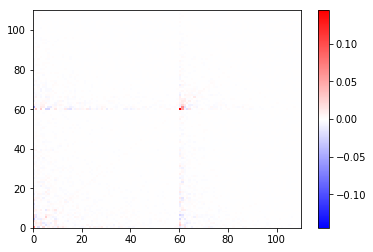

In [83]:
plt.pcolormesh(C_1_og, cmap='bwr', vmin = -C_1_og.max(), vmax=C_1_og.max())
plt.colorbar()
C_1_og.max(), C_1_og.min()

0.2823915041533578

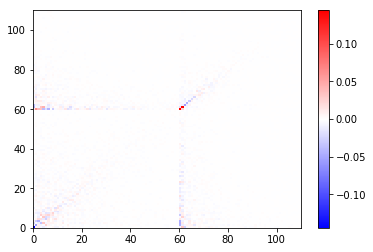

In [84]:
plt.pcolormesh(C_1_2sep, cmap='bwr', vmin = -C_1_og.max(), vmax=C_1_og.max())
plt.colorbar()
C_1_2sep.max()

0.13786110316379135

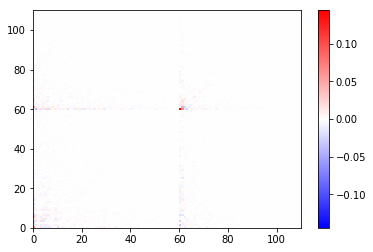

In [85]:
plt.pcolormesh(C_1_2, cmap='bwr', vmin = -C_1_og.max(), vmax=C_1_og.max())
plt.colorbar()
C_1_2.max()

In [36]:
import pickle 

# LIM_save = {}
# LIM_save['LIMd2'] = LIMd2
# LIM_save['var_dict'] = var_dict
# LIM_save['P_train_valid'] = P_train_valid
# LIM_save['P_train2'] = P_train2
# LIM_save['P_train'] = P_train
# LIM_save['E'] = E
# LIM_save['E_sic'] = E_sic
# LIM_save['W_all'] = W_all
# LIM_save['W_all2'] = W_all2
# LIM_save['W_all_valid'] = W_all_valid

# var_nms = [l+'_' for l in limvars]
# savename = ('L_mo'+str(mo)+'_'+ ''.join(var_nms)+ 'ntrunc'+str(ntrunc)+'_nmodes'+str(nmodes)+
#             '_nmodessic'+str(nmodes_sic)+'_031621.pkl')
# pickle.dump(LIM_save, open(savename, "wb" ) )

In [57]:
P_train.shape

(110, 400)

## Truncate validation data for all months: 

In [24]:
# Step 1 of truncation: all months for validation data...
mo = 1

wt=True
var_dict = {}
tot_var = {}
tot_var_eig = {}
W_all = {}
standard_factor = {}
E3 = {}
Ptrunc = {}

Ptrunc_valid_allmo = {}
E3_valid_allmo = {}
W_all_valid_allmo = {}

n=0

for k, var in enumerate(limvars): 
    X_var, var_dict = load_data(var, var_dict, fdic_ccsm4, remove_climo=True, detrend=True, verbose=True)
    
    tsamp = X_var.shape[1]
    nyears_train = int((tsamp*ntrain)/12)
    #nyears_valid = int(X_all_mpi.shape[2]/12)
    nyears_valid = int((tsamp*(1-ntrain))/12)
    X_t = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))
    
    for m in range(12):
        X_valid = X_t[:,nyears_train:,m]
        
        [Ptrunc_valid, E3_valid, tot_var_valid,
        tot_var_eig_valid, W_all_valid] = step1_compress_individual_var(X_valid, ntrunc, nmodes_sic, var_dict, n, 
                                                                        areawt=areacell[areawt_name[var]],
                                                                        wt=wt, sic_separate=sic_separate)
        if m ==0:
            Ptrunc_valid_var = np.zeros((Ptrunc_valid[var].shape[0],Ptrunc_valid[var].shape[1],12))
            E3_valid_var = np.zeros((E3_valid[var].shape[0],E3_valid[var].shape[1],12))
            W_all_valid_var = np.zeros((W_all_valid[var].shape[0],12))
            
        Ptrunc_valid_var[:,:,m] = Ptrunc_valid[var]
        E3_valid_var[:,:,m] = E3_valid[var]
        W_all_valid_var[:,m] = W_all_valid[var]
        
    Ptrunc_valid_allmo[var] = Ptrunc_valid_var
    E3_valid_allmo[var] = E3_valid_var
    W_all_valid_allmo[var] = W_all_valid_var
        
    del X_var

Loading tas
-----------------------------------------------------
completed in 22.809163808822632 seconds
-----------------------------------------------------
fraction in first 400 tas EOFs = 100.0
fraction in first 400 tas EOFs = 100.0
fraction in first 400 tas EOFs = 100.0
fraction in first 400 tas EOFs = 99.99999999999999
fraction in first 400 tas EOFs = 100.0
fraction in first 400 tas EOFs = 100.0
fraction in first 400 tas EOFs = 100.0
fraction in first 400 tas EOFs = 100.0
fraction in first 400 tas EOFs = 99.99999999999999
fraction in first 400 tas EOFs = 99.99999999999999
fraction in first 400 tas EOFs = 100.0
fraction in first 400 tas EOFs = 100.0
Loading tos
-----------------------------------------------------
completed in 58.683374643325806 seconds
-----------------------------------------------------
fraction in first 400 tos EOFs = 100.0
fraction in first 400 tos EOFs = 100.0
fraction in first 400 tos EOFs = 100.0
fraction in first 400 tos EOFs = 100.0
fraction in first 40

In [70]:
# Step 2 of truncation: all months for validation data...
ndof_all_valid = count_ndof_all(limvars, E3_valid, sic_separate=sic_separate)

[Ptrunc_all_valid_allmo, E3_all_valid_allmo,
 Ptrunc_sic_valid_allmo, 
 E_sic_valid_allmo] = stack_variable_eofs(limvars,ndof_all_valid, ntrunc, 
                                          Ptrunc_valid_allmo, E3_valid_allmo, var_dict, 
                                          nmonths=12, sic_separate=sic_separate)

P_train_valid_allmo = {}
Fvar_valid_allmo = {}
E_valid_allmo = {}

for m in range(12):
    print('Working on month: '+str(m))
    [P_train_valid_allmo[m], Fvar_valid_allmo[m], 
     E_valid_allmo[m]] = limkb.step2_multivariate_compress(Ptrunc_all_valid_allmo[:,:,m],nmodes, 
                                                           E3_all_valid_allmo[:,:,m], 
                                                           Ptrunc_sic_valid_allmo[:,:,m],
                                                           sic_separate=sic_separate)

In [33]:
# # Save truncated validation data: 
# P_save = {}
# P_save['Ptrain_valid_allmo'] = P_train_valid_allmo
# P_save['Fvar_valid_allmo'] = Fvar_valid_allmo
# P_save['E_valid_allmo'] = E_valid_allmo

# var_nms = [l+'_' for l in limvars]
# savename = 'P_train_valid_allmo_'+ ''.join(var_nms)+ 'ntrunc'+str(ntrunc)+'_nmodes'+str(nmodes)+'_nmodessic'+str(nmodes_sic)+'031521.pkl'
# pickle.dump(P_save, open(savename, "wb" ) )

In [68]:
# Open truncated validation data: 
var_nms = [l+'_' for l in limvars]
savename = 'P_train_valid_allmo_'+ ''.join(var_nms)+ 'ntrunc'+str(ntrunc)+'_nmodes'+str(nmodes)+'_nmodessic'+str(nmodes_sic)+'031521.pkl'

P_save = pickle.load(open(savename, "rb" ) )

P_train_valid_allmo = P_save['Ptrain_valid_allmo']
Fvar_valid_allmo = P_save['Fvar_valid_allmo']
E_valid_allmo = P_save['E_valid_allmo'] 

((110, 400), 77.07284151195552, (149504, 60))

In [23]:
# Get indices for each variable:
start = 0
for k, var in enumerate(limvars): 
    print('working on '+var)
    inds = var_dict[var]['var_ndof']
    var_inds = np.arange(start,start+inds,1)
    start = inds+start
    
    var_dict[var]['var_inds'] = var_inds

working on tas
working on tos
working on psl
working on sit
working on sic


## Load pre-existing L: 

In [414]:
import pickle 

var_nms = [l+'_' for l in limvars]
savename = ('L_mo'+str(mo)+'_'+''.join(var_nms)+ 'ntrunc'+str(ntrunc)+
            '_nmodes'+str(nmodes)+'_nmodessic'+str(nmodes_sic)+'_031021.pkl')

LIM_save = pickle.load(open(savename, "rb" ) )

LIMd2 = LIM_save['LIMd2']
var_dict = LIM_save['var_dict']
P_train_valid = LIM_save['P_train_valid'] 
P_train2 = LIM_save['P_train2'] 
P_train = LIM_save['P_train']
E = LIM_save['E'] 
E_sic = LIM_save['E_sic'] 
W_all = LIM_save['W_all'] 
W_all2 = LIM_save['W_all2'] 
W_all_valid = LIM_save['W_all_valid']

In [415]:
# Open truncated validation data: 
var_nms = [l+'_' for l in limvars]
savename = ('P_train_valid_allmo_'+ ''.join(var_nms)+ 'ntrunc'+str(ntrunc)+'_nmodes'+str(nmodes)+
            '_nmodessic'+str(nmodes_sic)+'_031521.pkl')

P_save = pickle.load(open(savename, "rb" ) )

P_train_valid_allmo = P_save['Ptrain_valid_allmo']
Fvar_valid_allmo = P_save['Fvar_valid_allmo']
E_valid_allmo = P_save['E_valid_allmo'] 

In [436]:
# Check that validation truncation is working: 
z = 1
x_dcomp_test1 = limkb.decompress_eof_separate_sic(P_train_valid_allmo[z],
                                            nmodes,nmodes_sic,E_valid_allmo[z],E_sic,limvars,var_dict,
                                            W_all_valid,sic_separate=sic_separate)

In [437]:
sic_dcomp_test.shape, X_t[:,nyears_train:,mo].shape

((56320, 400), (56320, 400))

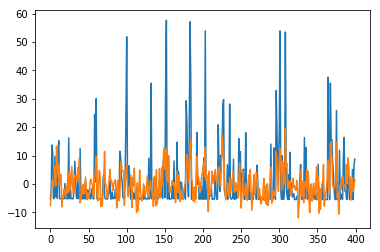

In [438]:
ii=10080
sic_dcomp_test1 = x_dcomp_test1[var_dict['sic']['var_inds'],:]

plt.plot(X_t[ii,nyears_train:,z])
plt.plot(sic_dcomp_test1[ii,:])

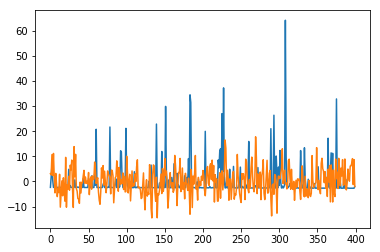

In [439]:
plt.plot(X_t[ii,nyears_train:,0])
plt.plot(sic_dcomp_test0[ii,:])

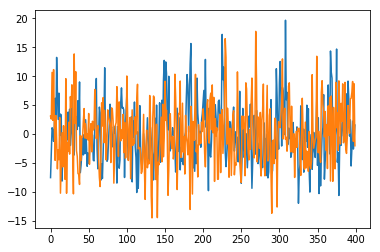

In [440]:
plt.plot(sic_dcomp_test1[ii,:])
plt.plot(sic_dcomp_test0[ii,:])

In [406]:
var_dumb = {}

X_var, var_dict = limkb.load_data('sic', var_dumb, fdic_ccsm4, remove_climo=True, 
                                  detrend=True, verbose=True)
    
tsamp = X_var.shape[1]
nyears_train = int((tsamp*ntrain)/12)
#nyears_valid = int(X_all_mpi.shape[2]/12)
nyears_valid = int((tsamp*(1-ntrain))/12)
X_t = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))

Loading sic
-----------------------------------------------------
completed in 215.31062841415405 seconds
-----------------------------------------------------


In [408]:
X_t[:,nyears_train:,:]

(56320, 400, 12)

In [ ]:
X_valid = X_t[:,nyears_train:,m]

## Run Forecast: 

In [47]:
# There is a bug with this forecast function function: It uses the eigenvectors and values to calculate Gt, 
#                                              but it's giving the same value for all lags in the forecast

# LIM forecasts for a range of monthly values (can specify a list of arbitrary values too)
lags = [0,1,2,3,4,5,6,7,8,9,10,11]
#lags = [1]
#lags = [0,3,6,12]
ntims = len(lags)

LIM_fcast_og = LIM_forecast(LIMd2,P_train_valid_allmo[mo],lags)

NameError: name 'P_train_valid_allmo' is not defined

In [63]:
# LIM forecasts for a range of monthly values (can specify a list of arbitrary values too)
#lags = [0,1,2,3,4,5,6,7,8,9,10,11]
lags = [0,1,2,3]
#lags = [1]
#lags = [0,3,6,12]
ntims = len(lags)

LIM_fcast = LIM_forecast_Gt(LIMd2,P_train_valid,lags)
#LIM_fcast = LIM_forecast_Gt(LIMd2,P_train_valid,lags)

t= 0
t= 1
t= 2
t= 3


In [61]:
# LIM forecasts for a range of monthly values (can specify a list of arbitrary values too)
#lags = [0,1,2,3,4,5,6,7,8,9,10,11]
lags = [0,1,2,3]
#lags = [1]
#lags = [0,3,6,12]
ntims = len(lags)

LIM_fcast_2sep = LIM_forecast_Gt(LIMd_2sep,P_train_valid,lags)
#LIM_fcast = LIM_forecast_Gt(LIMd2,P_train_valid,lags)

t= 0
t= 1
t= 2
t= 3


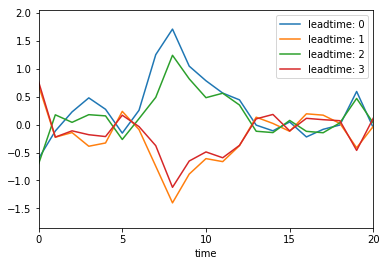

In [62]:
plt.plot(np.arange(0,400,1),LIM_fcast_2sep['x_forecast'][0,0,:], label='leadtime: 0')
plt.plot(np.arange(0,399,1),LIM_fcast_2sep['x_forecast'][1,0,1:], label='leadtime: 1')
plt.plot(np.arange(0,398,1),LIM_fcast_2sep['x_forecast'][2,0,2:], label='leadtime: 2')
plt.plot(np.arange(0,397,1),LIM_fcast_2sep['x_forecast'][3,0,3:], label='leadtime: 3')
# plt.plot(LIM_fcast['x_forecast'][4,0,:])
#plt.plot(LIM_fcast['x_forecast'][10,0,:])
plt.xlim(0,20)
plt.xticks(np.arange(0,400,5))
plt.xlim(0,20)
plt.xlabel('time')
plt.xlabel('time')
plt.legend()

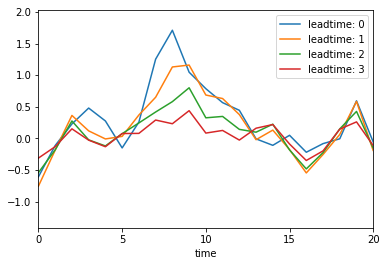

In [50]:
plt.plot(np.arange(0,400,1),LIM_fcast_og['x_forecast'][0,0,:], label='leadtime: 0')
plt.plot(np.arange(0,399,1),LIM_fcast_og['x_forecast'][1,0,1:], label='leadtime: 1')
plt.plot(np.arange(0,398,1),LIM_fcast_og['x_forecast'][2,0,2:], label='leadtime: 2')
plt.plot(np.arange(0,397,1),LIM_fcast_og['x_forecast'][3,0,3:], label='leadtime: 3')
# plt.plot(LIM_fcast['x_forecast'][4,0,:])
#plt.plot(LIM_fcast['x_forecast'][10,0,:])
plt.xlim(0,20)
plt.xticks(np.arange(0,400,5))
plt.xlim(0,20)
plt.xlabel('time')
plt.xlabel('time')
plt.legend()

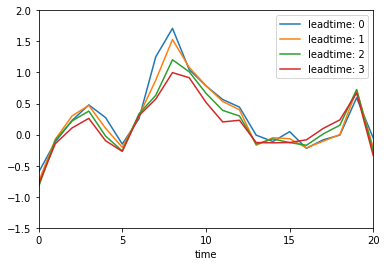

In [65]:
plt.plot(np.arange(0,400,1),LIM_fcast['x_forecast'][0,0,:], label='leadtime: 0')
plt.plot(np.arange(0,399,1),LIM_fcast['x_forecast'][1,0,1:], label='leadtime: 1')
plt.plot(np.arange(0,398,1),LIM_fcast['x_forecast'][2,0,2:], label='leadtime: 2')
plt.plot(np.arange(0,397,1),LIM_fcast['x_forecast'][3,0,3:], label='leadtime: 3')
# plt.plot(LIM_fcast['x_forecast'][4,0,:])
#plt.plot(LIM_fcast['x_forecast'][10,0,:])
plt.xlim(0,20)
plt.xticks(np.arange(0,400,5))
plt.xlim(0,20)
plt.ylim(-1.5,2.0)
plt.xlabel('time')
plt.xlabel('time')
plt.legend()

In [32]:
# x_forecast_dcomp = decompress_eof_separate_sic2(LIM_fcast[1]['x_forecast'],nmodes,nmodes_sic,E,E_sic,
#                                                 limvars,var_dict,W_all,Weights=True,
#                                                 sic_separate=sic_separate)

(0, 20)

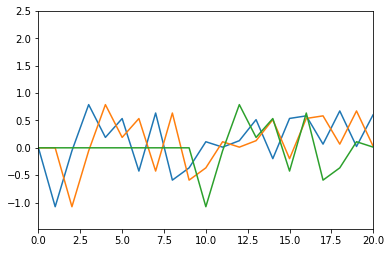

In [342]:
#plt.plot(LIM_fcast['x_forecast'][0,0,:])
plt.plot(LIM_fcast['x_forecast'][1,0,:])
plt.plot(LIM_fcast['x_forecast'][2,0,:])
# plt.plot(LIM_fcast['x_forecast'][3,0,:])
# plt.plot(LIM_fcast['x_forecast'][4,0,:])
plt.plot(LIM_fcast['x_forecast'][10,0,:])
plt.xlim(0,20)

In [377]:
E_valid_allmo[i].shape

(149504, 60)

In [381]:
x_forecast_dcomp = np.zeros((LIM_fcast['x_forecast'].shape[0],E.shape[0]+E_sic.shape[0],
                             LIM_fcast['x_forecast'].shape[2]))

for i,lag in enumerate(lags):
    print('Lag '+ str(lag))
    x_forecast_dcomp[i,:,:] = decompress_eof_separate_sic2(LIM_fcast['x_forecast'][i,:,:],
                                                           nmodes,nmodes_sic,E_valid_allmo[mo],
                                                           E_sic,limvars,var_dict,
                                                           W_all_valid,sic_separate=sic_separate)
    
#units = areacell_dict[areawt_name[var]][areawt_name[var]]['units']                                                           W_all,Weights=True,sic_separate=sic_separate)

Lag 0
Lag 1
Lag 2
Lag 3
Lag 4
Lag 5
Lag 6
Lag 7
Lag 8
Lag 9
Lag 10
Lag 11


(0, 100)

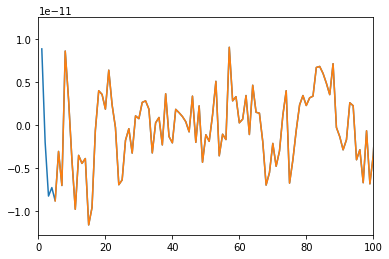

In [384]:
x_test = x_forecast_dcomp[0,var_dict['sic']['var_inds'],:]
x_test1 = x_forecast_dcomp[1,var_dict['sic']['var_inds'],:]
x_test2 = x_forecast_dcomp[5,var_dict['sic']['var_inds'],:]

#plt.plot(np.arange(0,400,1),x_test[10,:])
plt.plot(np.arange(1,400,1),x_test1[0,1:])
plt.plot(np.arange(5,400,1),x_test1[0,5:])
plt.xlim(0,100)

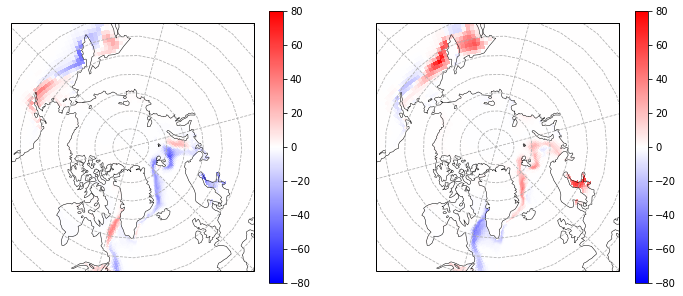

In [386]:
x_reshape = np.reshape(x_forecast_dcomp[1,var_dict[var]['var_inds'],:], (220,256,400))
x_reshape2 = np.reshape(x_forecast_dcomp[5,var_dict[var]['var_inds'],:], (220,256,400))

fig,ax = plt.subplots(1,2,figsize=(12,5), subplot_kw=arc_proj )
ax = ax.flatten()

sub_arctic_plot(ax[0],fig,x_reshape[:,:,20],var_dict[var]['lat'],var_dict[var]['lon'],
                maxv=80,minv=-80,cmap='bwr')
sub_arctic_plot(ax[1],fig,x_reshape2[:,:,20],var_dict[var]['lat'],var_dict[var]['lon'],
                maxv=80,minv=-80,cmap='bwr')


In [397]:
totsi_test = calc_tot_si(x_forecast_dcomp[2,var_dict['sic']['var_inds'],:], areacell[areawt_name[var]], units, var_dict[var]['lat'], cutoff=0.0)
totsi_test2 = calc_tot_si(x_forecast_dcomp[1,var_dict['sic']['var_inds'],:], areacell[areawt_name[var]], units, var_dict[var]['lat'], cutoff=0.0)

totsi_test[20:23], totsi_test2[20:23]

(array([-262171.27792294, -240874.18522135, -359316.88306582]),
 array([-240874.18522134, -359316.88306581, -254902.43346733]))

In [388]:
i = 0
var = 'sic'
tot_nh_sic_forecast_test = np.zeros((12,400))

units = areacell_dict[areawt_name[var]][areawt_name[var]]['units']

for m in range(12):
    x_forecast = x_forecast_dcomp[m,var_dict[var]['var_inds'],:]

    tot_nh_sic_forecast_test[m,:] = calc_tot_si(x_forecast, areacell[areawt_name[var]], 
                                                units, var_dict[var]['lat'], cutoff=0.0)

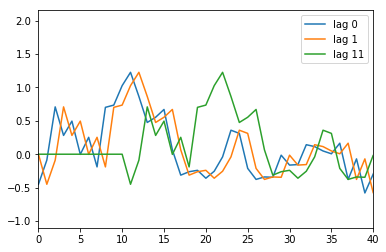

In [389]:
plt.plot(np.arange(0,400,1),tot_nh_sic_forecast_test[0, :]*1e-6, label= 'lag 0')
plt.plot(np.arange(0,400,1),tot_nh_sic_forecast_test[1, :]*1e-6, label= 'lag 1')
plt.plot(np.arange(0,400,1),tot_nh_sic_forecast_test[11, :]*1e-6, label= 'lag 11')
plt.xlim(0,40)
plt.legend()

In [80]:
validvars = ['sic']
v = {}
validation_stats = {}
valid_stats = {}
corr_tot = np.zeros((len(lags)))
ce_tot = np.zeros((len(lags)))
gm_var_ratio = np.zeros((len(lags)))

for k, var in enumerate(validvars): 
    X_var, _ = load_data(var, v, fdic_ccsm4, remove_climo=True, detrend=True, verbose=True)
    mo = 1
    for i,lag in enumerate(lags):
        print('Lag '+str(lag))
        
        tsamp = X_var.shape[1]
        nyears_train = int((tsamp*ntrain)/12)
        nyears_valid = int((tsamp*(1-ntrain))/12)

        X_t = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))
        
        step = mo+lag
        if step>11:
            step = step-12
            start_yr = nyears_train+1
        else: 
            start_yr = nyears_train
            
        x_truth = X_t[:,start_yr:,step]

        x_forecast = x_forecast_dcomp[i,var_dict[var]['var_inds'],:]

        units = areacell_dict[areawt_name[var]][areawt_name[var]]['units']
        tot_nh_sic_forecast = calc_tot_si(x_forecast, areacell[areawt_name[var]], 
                                          units, var_dict[var]['lat'], cutoff=0.0)
        tot_nh_sic_truth = calc_tot_si(x_truth, areacell[areawt_name[var]], 
                                       units, var_dict[var]['lat'],cutoff=0.0)

        corr_tot[i] = np.corrcoef(tot_nh_sic_truth,tot_nh_sic_forecast)[0,1]
        ce_tot[i] = LMR_utils.coefficient_efficiency(tot_nh_sic_truth,tot_nh_sic_forecast)

        error_var = np.nanvar(x_forecast - x_truth,axis=1,ddof=1)
        gm_error_var = global_mean(error_var,areacell[areawt_name[var]])

        truth_error_var = np.nanvar(x_truth,axis=1,ddof=1)
        gm_truth_var = global_mean(truth_error_var,areacell[areawt_name[var]])
        
        gm_var_ratio[i]=gm_error_var/gm_truth_var
        
        valid_stats['gm_var_ratio'] = gm_var_ratio
        valid_stats['corr_tot'] = corr_tot
        valid_stats['ce_tot'] = ce_tot
        
    validation_stats[var] = valid_stats

Loading sic
-----------------------------------------------------
completed in 29.356225967407227 seconds
-----------------------------------------------------
Lag 0
Lag 1
Lag 2
Lag 3
Lag 4
Lag 5
Lag 6
Lag 7
Lag 8
Lag 9
Lag 10
Lag 11


In [79]:
test = np.corrcoef(tot_nh_sic_truth,tot_nh_sic_forecast)[0,1]
test

0.886756258791682

In [108]:
# validvars = ['sic']
# v = {}

# for k, var in enumerate(validvars): 
#     X_var, _ = load_data(var, v, fdic_ccsm4, remove_climo=True, detrend=True, verbose=True)
    
#     mo = 1
#     tsamp = X_var.shape[1]
#     nyears_train = int((tsamp*ntrain)/12)
#     nyears_valid = int((tsamp*(1-ntrain))/12)

#     X_t = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))
#     x_truth = X_t[:,nyears_train:,mo+1]
    
#     x_forecast = x_forecast_dcomp[var_dict[var]['var_inds'],:]
    
#     units = areacell_dict[areawt_name[var]][areawt_name[var]]['units']
#     tot_nh_sic_forecast = calc_tot_si(x_forecast, areacell[areawt_name[var]], 
#                                       units, var_dict[var]['lat'], cutoff=0.0)
#     tot_nh_sic_truth = calc_tot_si(x_truth, areacell[areawt_name[var]], 
#                                    units, var_dict[var]['lat'],cutoff=0.0)
    
#     corr_tot_sic = np.corrcoef(tot_nh_sic_truth,tot_nh_sic_forecast)[0,1]
#     ce_tot_sic = LMR_utils.coefficient_efficiency(tot_nh_sic_truth,tot_nh_sic_forecast)
    
#     error_var = np.nanvar(x_forecast - x_truth,axis=1,ddof=1)
#     gm_error_var = global_mean(error_var,areacell[areawt_name[var]])
    
#     truth_error_var = np.nanvar(x_truth,axis=1,ddof=1)
#     gm_truth_var = global_mean(truth_error_var,areacell[areawt_name[var]])

Loading sic
-----------------------------------------------------
completed in 86.63140058517456 seconds
-----------------------------------------------------


In [64]:
validation_stats['sic']['gm_var_ratio'].shape, validation_stats['sic']['corr_tot'].shape, validation_stats['sic']['ce_tot'].shape

((12,), (12, 400), (12, 400))

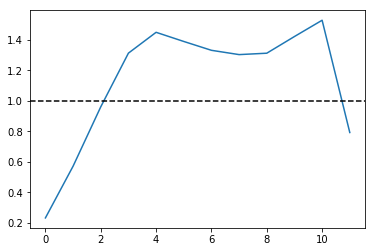

In [81]:
plt.plot(validation_stats['sic']['gm_var_ratio'])
plt.axhline(1,linestyle='--', color='k')

Text(0.5,1,'Februrary')

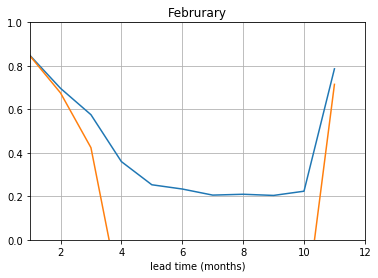

In [90]:
plt.plot(validation_stats['sic']['corr_tot']**2, label='Correlation')
plt.plot(validation_stats['sic']['ce_tot'],label='CE')
#plt.axhline(0,linestyle='--', color='k')
plt.ylim(0,1)
plt.xlim(1,12)
plt.grid(axis='both')
plt.xlabel('lead time (months)')
plt.title(month_names[mo])

In [73]:
validation_stats['sic']['corr_tot'].shape

(12, 400)

In [51]:
validation_stats['sic'].keys()

dict_keys(['gm_var_ratio', 'corr_tot', 'ce_tot'])

In [57]:
validation_stats['sic']['corr_tot'].shape

(12, 400)

In [ ]:
LIMd['G']**t

In [37]:
def arctic_mean(var, areacell, cutoff=0.0): 
    tot_nh_var = var*areacell
    if len(lat.shape)<=1:
        lat_inds = np.where(var_dict[var]['lat']>cutoff)
        tot_nh_var = np.nansum(np.nansum(tot_nh_var[:,lat_inds,:],axis=1),axis=1)
    
        wt_sum = np.nansum(np.nansum(cellarea[lat_inds,:],axis=0),axis=0)
    else:
        lat_inds = np.where(var_dict[var]['lat']>cutoff)
        tot_nh_var = np.nansum(np.nansum(tot_nh_var[:,lat_inds],axis=1),axis=1)
    
        wt_sum = np.nansum(np.nansum(cellarea[lat_inds],axis=0),axis=0)
    
    var_mn = tot_nh_var/wt_sum
    
    return var_mn

In [38]:
def global_mean(var, areacell): 
    """Assumes var is dimensions (nlat*nlon,time)
    """
    
    tot_nh_var = var*areacell
    
    tot_var = np.nansum(tot_nh_var,axis=0)
    wt_sum = np.nansum(areacell,axis=0)
    
    var_mn = tot_var/wt_sum
    
    return var_mn

In [39]:
def calc_tot_si(var, areacell, units, lat, cutoff=0.0): 
    if units == 'm2':
        cellarea = (areacell*1e-6)[:,np.newaxis]
    else: 
        cellarea = areacell[:,np.newaxis]
        
    if var.max()>2:
        Var = var/100.0
    else: 
        Var = var
        
    nh_var = Var*cellarea
    
    if len(lat.shape)<=1:
        lat_inds = np.where(lat>cutoff)
        tot_nh_var = np.nansum(nh_var[lat_inds,:].squeeze(),axis=0)
    else:
        lat_1d = np.reshape(lat,(var.shape[0]))
        lat_inds = np.where(lat_1d>cutoff)
        tot_nh_var = np.nansum(nh_var[lat_inds,:].squeeze(),axis=0)
    
    return tot_nh_var
    

In [40]:
def calc_gm_polar_variance(valid_var,valid_var_mon,fields,lat,lon):
    valid_variance = {}
    gm_mon = np.zeros((12))
    polar_mon = np.zeros((2,12))
    nlat = lat.shape[0]
    nlon = lon.shape[0]

    for v in fields.keys():
        print(v)
        var = np.reshape(valid_var[fields[v]],[nlat,nlon])
        var_mon = np.reshape(valid_var_mon[fields[v],:].T,[12,nlat,nlon])

        gm,_,_ = LMR_utils.global_hemispheric_means(var,lat)
        polar = polar_regional_means(var,lat,lon)
        polar_mon = polar_regional_means(var_mon,lat,lon)
        for m in range(12):
            gm_mon[m],_,_ = LMR_utils.global_hemispheric_means(var_mon[m,:,:],lat)

        valid_variance[v+'_gm'] = gm
        valid_variance[v+'_gm_mon'] = gm_mon
        valid_variance[v+'_polarm'] = polar
        valid_variance[v+'_polarm_mon'] = polar_mon
        
    return valid_variance

In [ ]:
yrs_mo = np.reshape(var_dict[var]['time'],(int(tsamp/12),12))

yrs_train = yrs_mo[0:nyears_train,mo]
yrs_valid = yrs_mo[nyears_train:,mo+1]

## EOF decomposition: 

In [ ]:
[Ptrunc, E3, Ptrunc_sic, E_sic,
 W_train, sf_train,
 tot_var, tot_var_eig] = limkb.step1_compress_individual_vars(X_train, limvars, ntrunc, 
                                                              nmodes_sic, var_dict,X_all.shape[0],
                                                              var_dict['sic']['var_ndof'], 
                                                              wt=True,sic_separate=sic_separate)


[P_train, Fvar, E] = limkb.step2_multivariate_compress(Ptrunc,nmodes, E3, Ptrunc_sic, 
                                                       sic_separate=sic_separate)

In [ ]:
[Ptrunc2, E3_2, Ptrunc_sic2, 
 E_sic2, W_train2, sf_train2] = limkb.compress_individual_vars2(X_train2, limvars, ntrunc, nmodes_sic, var_dict, 
                                                                X_all.shape[0], var_dict['sic']['var_ndof'], 
                                                                sic_separate=sic_separate)
    
[P_train2, Fvar2, E2] = limkb.step2_multivariate_compress(Ptrunc2,nmodes, E3_2, 
                                                          Ptrunc_sic2, sic_separate=sic_separate)

In [ ]:
[Ptrunc_valid, E3_valid, Ptrunc_sic_valid, 
 E_sic_valid, W_valid, sf_valid] = limkb.compress_individual_vars2(X_valid, limvars, ntrunc, nmodes_sic, 
                                                                   var_dict,X_all.shape[0], 
                                                                   var_dict['sic']['var_ndof'], 
                                                                   sic_separate=sic_separate)

[P_valid, Fvar_valid, E_valid] = limkb.step2_multivariate_compress(Ptrunc_vlaid,nmodes, E3_valid, 
                                                                   Ptrunc_sic_valid, sic_separate=sic_separate)

In [195]:
# prepare the data to train and test the LIM. 
# separate data into training the validation sets 
tsamp = X_all.shape[1]
nyears = tsamp/12
ntrain_yrs = int(np.floor((tsamp/12)*ntrain)*12)
train_inds = np.arange(0,ntrain_yrs)
valid_inds = np.arange(ntrain_yrs,tsamp,1)

x_train = P_train
x_train2 = P_train2
x_valid = P_valid

print('training data shape: ',x_train.shape)
print('validation data shape: ',x_valid.shape)

training data shape:  (60, 600)
validation data shape:  (60, 400)


In [ ]:
# x_train_dcomp = decompress_eof_separate_sic2(P_train,nmodes,nmodes_sic,E,E_sic,
#                                              limvars,var_dict,W_train,Weights=True,
#                                              sic_separate=sic_separate)

In [196]:
# # climo standardized variance for error normalization 
# #  in training and validation (1=no skill)
# # EOF space only
# if sic_separate is True: 
#     E_x_train = lim.decompress_eof_separate_sic(x_train,nmodes,nmodes_sic,E,E_sic)
#     E_x_valid = lim.decompress_eof_separate_sic(x_valid,nmodes,nmodes_sic,E_valid,E_sic_valid)

# else: 
#     E_x_train = np.matmul(E,x_train)
#     E_x_valid = np.matmul(E_valid,x_valid)

# E_x_train[np.isclose(E_x_train,0,atol=10e-10)] = np.nan
# E_x_valid[np.isclose(E_x_valid,0,atol=10e-10)] = np.nan
    
# nyrs_train = int(E_x_train.shape[1]/12)
# nyrs_valid = int(E_x_valid.shape[1]/12)
# nlalo = E_x_train.shape[0]

# # train_var_mon = np.nanvar(np.reshape(E_x_train,(nlalo,nyrs_train,12)),
# #                        axis=1,ddof=1)
# # valid_var_mon = np.nanvar(np.reshape(E_x_valid,(nlalo,nyrs_valid,12)),
# #                        axis=1,ddof=1)
# train_var = np.nanvar(E_x_train,axis=1,ddof=1)
# valid_var = np.nanvar(E_x_valid,axis=1,ddof=1)

# # FULL FIELD versions of the variance 
# train_var_full = np.nanvar(X_train,axis=1,ddof=1)
# valid_var_full = np.nanvar(X_valid,axis=1,ddof=1)

# # valid_var_mon_full = np.var(np.reshape(X_mpi,(nvars*ndof,nyrs_valid,12)),
# #                             axis=1,ddof=1)

In [49]:
# train the LIM
LIMd, G = lim.LIM_train(tau,x_train)
print('Training LIM with tau = '+str(tau))

Training LIM with tau = 1


In [51]:
LIMd2, G2 = lim.LIM_train_flex(tau,x_train, x_train2)

In [52]:
# LIM forecasts for a range of monthly values (can specify a list of arbitrary values too)
lags = [1]
#lags = [0,3,6,12]
ntims = len(lags)

# training data
#truth = np.real(np.matmul(E,x_train))
#truth = X[:,train_inds]
#LIMfd_train = LIM_utils.LIM_forecast(LIMd,x_train,lags,E,truth)

# validation data
#truth = np.real(np.matmul(E,x_valid))
LIMfd_valid = lim.LIM_forecast_test(G,x_valid,lags,E_valid,truth,yrs_valid,len(limvars),ndof,
                                    nmodes=nmodes,nmodes_sic=nmodes_sic,E_sic=E_sic_valid,
                                    sic_separate=sic_separate)

t= 1


ValueError: could not broadcast input array from shape (149504) into shape (225280)

In [141]:
truth_state = {}
nlat = lat_2d[:,0].shape[0]
nlon = lon_2d[0,:].shape[0]

for v,var in enumerate(limvars):
    print('working on '+str(var))
    if sic_separate is True: 
        Truth = lim.decompress_eof(truth,E,E_sic=E_sic,
                                   nmodes=nmodes,nmodes_sic=nmodes_sic,
                                   sic_separate=sic_separate)
    else: 
        Truth = np.matmul(E,truth)
#            print(Truth.shape)
    truth_3d = np.reshape(Truth[fields[var],:].T,[Truth.shape[1],nlat,nlon])
    truth_gm,_,_ = LMR_utils.global_hemispheric_means(truth_3d[1:,:,:],lat_2d[:,0])
    truth_pm = lim.polar_regional_means(truth_3d[1:,:,:],lat_2d[:,0],lon_2d[0,:])

    truth_state[var+'_gm_mo_'+str(mo)] = truth_gm
    truth_state[var+'_pm_mo_'+str(mo)] = truth_pm
    truth_state[var+'_full_mo_'+str(mo)] = truth_3d

working on tas
working on psl
working on tos
working on sit
working on sic


In [142]:
LIMfd_valid['x_forecast'].shape

(1, 120, 1000)

In [143]:
forecast = {}

for v,var in enumerate(limvars):
    print('working on '+str(var))
    if sic_separate is True: 
        fcast = lim.decompress_eof(LIMfd_valid['x_forecast'][0,:,:],E,E_sic=E_sic,
                                      nmodes=nmodes,nmodes_sic=nmodes_sic,
                                      sic_separate=sic_separate)
    else: 
        fcast = np.matmul(E,LIMfd_valid['x_forecast'][0,:,:])
#            print(Truth.shape)
    forecast_3d = np.reshape(fcast[fields[var],:].T,[fcast.shape[1],nlat,nlon])
    forecast_gm,_,_ = LMR_utils.global_hemispheric_means(forecast_3d[1:,:,:],lat_2d[:,0])
    forecast_pm = lim.polar_regional_means(forecast_3d[1:,:,:],lat_2d[:,0],lon_2d[0,:])

    forecast[var+'_gm_mo_'+str(mo)] = forecast_gm
    forecast[var+'_pm_mo_'+str(mo)] = forecast_pm
    forecast[var+'_full_mo_'+str(mo)] = forecast_3d

working on tas
working on psl
working on tos
working on sit
working on sic


In [144]:
ce = {}
corr = {}

for n,var in enumerate(limvars):
    print('working on '+str(var))
    ce_pm_lag = np.zeros((2))
    corr_pm_lag = np.zeros((2))

    ce_gm = LMR_utils.coefficient_efficiency(truth_state[var+'_gm_mo_'+str(mo)],
                                                    forecast[var+'_gm_mo_'+str(mo)])
    corr_gm = np.corrcoef(truth_state[var+'_gm_mo_'+str(mo)],
                                 forecast[var+'_gm_mo_'+str(mo)])[0,1]

    for n in range(2):
        ce_pm_lag[n] = LMR_utils.coefficient_efficiency(truth_state[var+'_pm_mo_'+str(mo)][n,:],
                                                          forecast[var+'_pm_mo_'+str(mo)][n,:])
        corr_pm_lag[n] = np.corrcoef(truth_state[var+'_pm_mo_'+str(mo)][n,:],
                                       forecast[var+'_pm_mo_'+str(mo)][n,:])[0,1]

    ce[var+'_gm_mo_'+str(mo)] = ce_gm
    ce[var+'_pm_mo_'+str(mo)] = ce_pm_lag
    corr[var+'_gm_mo_'+str(mo)] = corr_gm
    corr[var+'_pm_mo_'+str(mo)] = corr_pm_lag

working on tas
working on psl
working on tos
working on sit
working on sic


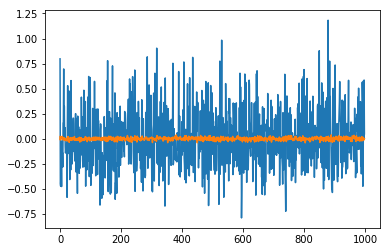

In [148]:
plt.plot(forecast['tas_gm_mo_'+str(mo)])
plt.plot(truth_state['tas_gm_mo_'+str(mo)])

In [145]:
for var in limvars: 
    print(var)
    print('GM CE = '+str(ce[var+'_gm_mo_'+str(mo)])+' GM Corr = '+ str(corr[var+'_gm_mo_'+str(mo)]))

tas
GM CE = -403.25880941645715 GM Corr = -0.024220206464738832
psl
GM CE = -741.4342540101476 GM Corr = -0.055287853100057884
tos
GM CE = -264.07100597064516 GM Corr = -0.03161414428771794
sit
GM CE = -342.94229872323535 GM Corr = -0.04336836101191847
sic
GM CE = -17.072935880843577 GM Corr = -0.019626058348466802


In [38]:
ce_ar1, corr_ar1= lim.calc_ce_corr_ar_lags(X_valid,X_train,lags,limvars,
                                           lat_2d[:,0],lon_2d[0,:])

working on tas
working on psl
working on tos
working on sic


In [39]:
ce_ar1_valid, corr_ar1_valid = lim.calc_ce_corr_ar_lags(X_valid,X_valid,lags,
                                                        limvars,lat_2d[:,0], lon_2d[0,:])

working on tas
working on psl
working on tos


/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_utils.py:797: RuntimeWarning: invalid value encountered in true_divide
  lac = cov / std


working on sic


In [ ]:
X_valid.shape

In [ ]:
Xv.shape

In [112]:
v = 3
var = 'tos'
Xt = X_valid
Xv = X_valid
lat = lat_2d[:,0]
lon = lon_2d[0,:]
l = np.arange(1,2,1)

ar1_gm = np.zeros((len(l),Xv.shape[2]))
ar1_pm = np.zeros((len(l),2,Xv.shape[2]))
ce_pm = np.zeros((len(l),2))
corr_pm = np.zeros((len(l),2))

for i,lag in enumerate(l):
    ar1_forecast, ar1_factor = lim.red_noise_forecast_ar1(Xt[v,:].T,Xv[v,:].T,lead=lag)
    ar1_forecast_3d = np.reshape(ar1_forecast,(ar1_forecast.shape[0],nlat,nlon))
    X_valid_3d = np.reshape(Xv[v,:].T,(Xv.shape[2],nlat,nlon))
    ar1_gm[i,lag:],_,_ = LMR_utils.global_hemispheric_means(ar1_forecast_3d,lat)
    ar1_pm[i,:,lag:] = lim.polar_regional_means(ar1_forecast_3d,lat,lon)

    true_gm,_,_ = LMR_utils.global_hemispheric_means(X_valid_3d,lat)
    true_pm = lim.polar_regional_means(X_valid_3d,lat,lon)

    ce_gm = LMR_utils.coefficient_efficiency(true_gm[lag:],ar1_gm[i,lag:])
    corr_gm = np.corrcoef(true_gm[lag:],ar1_gm[i,lag:])[0,1]
    for n in range(2):
        ce_pm[i,n] = LMR_utils.coefficient_efficiency(true_pm[n,lag:],ar1_pm[i,n,lag:])
        corr_pm[i,n] = np.corrcoef(true_pm[n,lag:],ar1_pm[i,n,lag:])[0,1]

/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_utils.py:793: RuntimeWarning: invalid value encountered in true_divide
  lac = cov / std


In [122]:
np.nanmin(ar1_factor), Xv[v,:].T.shape

(-0.00033366700033366306, (12000, 3240))

In [125]:
ar1_forecast.shape

(11999, 3240)

In [106]:
corr_gm

0.9848644683160668

In [110]:
np.corrcoef(true_gm[1:],ar1_gm[0,1:])[0,1]

0.9848644683160668

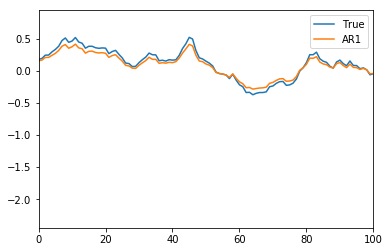

In [108]:
plt.plot(true_gm[1:], label='True')
plt.plot(ar1_gm[0,2:], label='AR1')
plt.xlim(0,100)
plt.legend()

#### check in eof space: 

In [ ]:
truth_eof = np.matmul(E_sic,x_valid_sic)
truth_eof_gm,_,_ = LMR_utils.global_hemispheric_means(np.reshape(truth_eof.T,(7212,45,72)), lat_2d[:,0])

In [ ]:
truth_state['sic_gm'].shape

In [ ]:
plt.plot(truth_state['sic_gm'][0,:],label='truth')
plt.plot(forecast['sic_gm'][0,:],label='forecast')
plt.plot(truth_eof_gm,label='truth eof')
plt.legend()
plt.title('GM SIC')

In [ ]:
k=0
ce_test = LMR_utils.coefficient_efficiency(truth_eof_gm,forecast[var+'_gm'][k,k:])
corr_test = np.corrcoef(truth_eof_gm,forecast[var+'_gm'][k,k:])[0,1]
corr_test, ce_test

In [148]:
corr_ar1_valid['tos_gm']

array([0.        , 0.98486447, 0.96391541, 0.93804171, 0.90800665,
       0.87682375, 0.84661718, 0.81847671, 0.79224612, 0.76764925,
       0.74339473, 0.71778917, 0.69008076])

In [ ]:
# load training data...
wt=True
var_dict = {}
tot_var = {}
tot_var_eig = {}
W_all = {}
standard_factor = {}
E3 = {}
Ptrunc = {}

# if sic_separate is True: 
#         E3 = np.zeros([X_allshape-X_sicshape,ntrunc*(nvars-1)])
# else:  
#     E3 = np.zeros([X_allshape,ntrunc*(nvars)])
n=0

for k, var in enumerate(limvars): 
    X_var, var_dict = load_data(var, var_dict, fdic_ccsm4, remove_climo=True, detrend=True, verbose=True)
    
    mo = 1
    tsamp = X_var.shape[1]
    nyears_train = int((tsamp*ntrain)/12)
    #nyears_valid = int(X_all_mpi.shape[2]/12)
    nyears_valid = int((tsamp*(1-ntrain))/12)

    X_t = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))
    X_train = X_t[:,0:nyears_train,mo]
    X_train2 = X_t[:,0:nyears_train,mo+1]
    X_valid = X_t[:,nyears_train:,mo]
    truth = X_t[:,nyears_train:,mo+1]
    ntime = X_train.shape[1]
     
    if (sic_separate is True) & (var is 'sic'):
            trunc = nmodes_sic
    else: 
        trunc = ntrunc
        
    if len(var_dict[var]['lat'].shape)<2:
        nlon = var_dict[var]['lon'].shape[0]
        nlat = var_dict[var]['lat'].shape[0]
        lat = var_dict[var]['lat'][:,np.newaxis]*np.ones((nlat,nlon))
    else: 
        lat = var_dict[var]['lat']

    [eofs_out, svals_out, pcs_out, 
     total_var, total_var_eig, 
     var_expl_by_retained, W] = limkb.eof_decomp_1var(X_train,lat,var_dict[var]['var_ndof'],
                                                      X_train.shape[1],trunc,Weight=wt)
    
    tot_var[var] = total_var
    tot_var_eig[var] = total_var_eig
    W_all[var] = np.squeeze(W)
    
    if k == 0:
        print('fraction in first '+str(ntrunc)+ ' '+limvars[k]+' EOFs = '+str(var_expl_by_retained))
                                                                              
        # projection
        P_var = np.matmul(eofs_out.T,W*np.nan_to_num(X_train))
        standard_factor[var] = np.sqrt(np.sum(svals_out*svals_out)/(ntime-1))

        Ptrunc[var] = P_var/standard_factor[var]

        # reverse operator from EOFs to grid point space
        E3[var] = eofs_out*standard_factor[var]
        n=n+1

    elif (sic_separate is True) & (var is 'sic'):
        print('fraction in first '+str(nmodes_sic)+ ' '+limvars[k]+' EOFs = '+str(var_expl_by_retained))
        print('...separately')

        Pvar_sic = np.matmul(eofs_out.T,W*np.nan_to_num(X_train))
        standard_factor[var] = np.sqrt(np.sum(svals_out*svals_out)/(ntime-1))

        Ptrunc['sic'] = Pvar_sic/standard_factor[var]
        E['sic'] = eofs_out*standard_factor[var]

    else:
        print('fraction in first '+str(ntrunc)+ ' '+limvars[k]+' EOFs = '+str(var_expl_by_retained))

        # projection
        P_var = np.matmul(eofs_out.T,W*np.nan_to_num(X_train))
        standard_factor[var] = np.sqrt(np.sum(svals_out*svals_out)/(ntime-1))

        Ptrunc[var] = P_var/standard_factor[var]

        # reverse operator from EOFs to grid point space
        E3[var] = eofs_out*standard_factor[var]
        n=n+1

#             # projection
#             P_var = np.matmul(eofs_out.T,W*np.nan_to_num(X_train[var_dict[var]['var_inds'],:]))
#             standard_factor[var] = np.sqrt(np.sum(svals_out*svals_out)/(ntime-1))
            
#             Ptrunc = np.concatenate((Ptrunc,P_var/standard_factor[var]),axis=0)

#             # reverse operator from EOFs to grid point space
#             E3[var_dict[var]['var_inds'],n*ntrunc:(n+1)*ntrunc] = eofs_out*standard_factor[var]
#             n=n+1

    del X_var
    
# if k == 0: 
#     X_all = X_var
# else: 
#     X_all = np.concatenate((X_all,X_var),axis=0)